Mapping of Shapley values onto compound structures

In [1]:
import os
os.environ["http_proxy"] = "http://web-proxy.informatik.uni-bonn.de:3128"
os.environ["https_proxy"] = "http://web-proxy.informatik.uni-bonn.de:3128"

Import libraries

In [2]:
import yaml

import torch

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import imageio.v2 as imageio

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from src import const
from src.molecule_builder import get_bond_order
from src.visualizer import load_molecule_xyz, load_xyz_files
from src.datasets import get_dataloader
from src.lightning import DDPM

from tqdm.auto import tqdm

In [3]:
COORDINATES_FOLDER = "trajectories/zinc_difflinker/zinc_final_test/chains_hausdorff_distance_0.5_seed_42_no_transform_transformation_seed_42_COM_addition_alternate_viz/"
SHAPLEY_VALUES_FOLDER = "results/shapley_values/"

with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)

checkpoint = config['CHECKPOINT']
DATA = config['DATA']
prefix = config['PREFIX']
device = config['DEVICE'] if torch.cuda.is_available() else 'cpu'
NUM_SAMPLES = config['NUM_SAMPLES']
SEED_LIST = [42,1240,14085]

model = DDPM.load_from_checkpoint(checkpoint, map_location=device)
model.val_data_prefix = prefix

print(f"Running device: {device}")

if DATA is not None:
    model.data_path = DATA

model = model.eval().to(device)
model.setup(stage='val')
dataloader = get_dataloader(
    model.val_dataset,
    batch_size=1
)

/home/mastropietro/anaconda3/envs/diff_explainer/lib/python3.10/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
Lightning automatically

Running device: cuda:1


In [4]:
data_list = []
sampled = 0
data_dict = {}
for data in dataloader:
    if sampled < NUM_SAMPLES:
        data_list.append(data)
        sampled += 1

# #print all fragment masks, linker masks, and anchor masks
# for i in range(len(data_list)):
#     data_dict[i] = {}
#     data_dict[i]["fragment_mask"] = data_list[i]['fragment_mask'].squeeze(0)
#     data_dict[i]["linker_mask"] = data_list[i]['linker_mask'].squeeze(0)
#     data_dict[i]["anchors"] = data_list[i]['anchors'].squeeze(0)

In [5]:
#load shapley values

shapley_values_all_dict = {}

for i in range(NUM_SAMPLES):
    shapley_values_all_dict[i] = []
    
    for seed in SEED_LIST:
        shapley_values_seed = []
        with open(f"{SHAPLEY_VALUES_FOLDER}explanations_hausdorff_distance_0.5_seed_{str(seed)}_no_transform_transformation_seed_42_COM_addition/phi_atoms_{i}.txt", "r") as f:
            f.readline()
            f.readline()
            
            for line in f:
                if line == "\n":
                    break
                row = line.strip().split(",")
                shapley_values_seed.append(float(row[1]))
        shapley_values_all_dict[i].append(shapley_values_seed)
        

In [6]:
len(shapley_values_all_dict[0])

3

In [7]:
def draw_sphere_xai(ax, x, y, z, size, color, alpha):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    xs = size * np.outer(np.cos(u), np.sin(v))
    ys = size * np.outer(np.sin(u), np.sin(v)) #* 0.8
    zs = size * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x + xs, y + ys, z + zs, rstride=2, cstride=2, color=color, alpha=alpha)
    
def plot_molecule_xai(ax, positions, atom_type, alpha, spheres_3d, hex_bg_color, is_geom, fragment_mask=None, phi_values=None):
    x = positions[:, 0]
    y = positions[:, 1]
    z = positions[:, 2]
    # Hydrogen, Carbon, Nitrogen, Oxygen, Flourine

    idx2atom = const.GEOM_IDX2ATOM if is_geom else const.IDX2ATOM

    colors_dic = np.array(const.COLORS)
    radius_dic = np.array(const.RADII)
    area_dic = 1500 * radius_dic ** 2

    areas = area_dic[atom_type]
    radii = radius_dic[atom_type]
    colors = colors_dic[atom_type]

    if fragment_mask is None:
        fragment_mask = torch.ones(len(x))

    for i in range(len(x)):
        for j in range(i + 1, len(x)):
            p1 = np.array([x[i], y[i], z[i]])
            p2 = np.array([x[j], y[j], z[j]])
            dist = np.sqrt(np.sum((p1 - p2) ** 2))
            atom1, atom2 = idx2atom[atom_type[i]], idx2atom[atom_type[j]]
            draw_edge_int = get_bond_order(atom1, atom2, dist)
            line_width = (3 - 2) * 2 * 2
            draw_edge = draw_edge_int > 0
            if draw_edge:
                if draw_edge_int == 4:
                    linewidth_factor = 1.5
                else:
                    linewidth_factor = 1
                linewidth_factor *= 0.5
                ax.plot(
                    [x[i], x[j]], [y[i], y[j]], [z[i], z[j]],
                    linewidth=line_width * linewidth_factor * 2,
                    c=hex_bg_color,
                    alpha=alpha
                )

    

    if spheres_3d:
        
        for i, j, k, s, c, f, phi in zip(x, y, z, radii, colors, fragment_mask, phi_values):
            if f == 1:
                alpha = 1.0
                if phi > 0:
                    c = 'red'

            draw_sphere_xai(ax, i.item(), j.item(), k.item(), 0.5 * s, c, alpha)

    else:
        phi_values_array = np.array(phi_values)

        #draw fragments
        fragment_mask_on_cpu = fragment_mask.cpu().numpy()
        colors_fragment = colors[fragment_mask_on_cpu == 1]
        x_fragment = x[fragment_mask_on_cpu == 1]
        y_fragment = y[fragment_mask_on_cpu == 1]
        z_fragment = z[fragment_mask_on_cpu == 1]
        areas_fragment = areas[fragment_mask_on_cpu == 1]
        
        # Calculate the gradient colors based on phi values
        cmap = plt.cm.get_cmap('coolwarm_r') #reversed heatmap for distance-based importance
        norm = plt.Normalize(vmin=min(phi_values_array), vmax=max(phi_values_array))
        colors_fragment_shadow = cmap(norm(phi_values_array))
        
        # ax.scatter(x_fragment, y_fragment, z_fragment, s=areas_fragment, alpha=0.9 * alpha, c=colors_fragment)

        ax.scatter(x_fragment, y_fragment, z_fragment, s=areas_fragment, alpha=0.9 * alpha, c=colors_fragment, edgecolors=colors_fragment_shadow, linewidths=5, rasterized=False)

        #draw non-fragment atoms
        colors = colors[fragment_mask_on_cpu == 0]
        x = x[fragment_mask_on_cpu == 0]
        y = y[fragment_mask_on_cpu == 0]
        z = z[fragment_mask_on_cpu == 0]
        areas = areas[fragment_mask_on_cpu == 0]
        ax.scatter(x, y, z, s=areas, alpha=0.9 * alpha, c=colors, rasterized=False)
        
def plot_data3d_xai(positions, atom_type, is_geom, camera_elev=0, camera_azim=0, save_path=None, spheres_3d=False,
                bg='black', alpha=1., fragment_mask=None, phi_values=None):
    black = (0, 0, 0)
    white = (1, 1, 1)
    hex_bg_color = '#FFFFFF' if bg == 'black' else '#000000' #'#666666'

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.set_aspect('auto')
    ax.view_init(elev=camera_elev, azim=camera_azim)
    if bg == 'black':
        ax.set_facecolor(black)
    else:
        ax.set_facecolor(white)
    ax.xaxis.pane.set_alpha(0)
    ax.yaxis.pane.set_alpha(0)
    ax.zaxis.pane.set_alpha(0)
    ax._axis3don = False

    if bg == 'black':
        ax.w_xaxis.line.set_color("black")
    else:
        ax.w_xaxis.line.set_color("white")

    plot_molecule_xai(
        ax, positions, atom_type, alpha, spheres_3d, hex_bg_color, is_geom=is_geom, fragment_mask=fragment_mask, phi_values=phi_values
    )

    max_value = positions.abs().max().item()
    axis_lim = min(40, max(max_value / 1.5 + 0.3, 3.2))
    ax.set_xlim(-axis_lim, axis_lim)
    ax.set_ylim(-axis_lim, axis_lim)
    ax.set_zlim(-axis_lim, axis_lim)
    dpi = 300 if spheres_3d else 300 #it was 120 and 50

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.0, dpi=dpi)
        # plt.savefig(save_path, bbox_inches='tight', pad_inches=0.0, dpi=dpi, transparent=True)

        if spheres_3d:
            img = imageio.imread(save_path)
            img_brighter = np.clip(img * 1.4, 0, 255).astype('uint8')
            imageio.imsave(save_path, img_brighter)
    else:
        plt.show()
    plt.close()

def visualize_chain_xai(
        path, spheres_3d=False, bg="black", alpha=1.0, wandb=None, mode="chain", is_geom=False, fragment_mask=None, phi_values=None
):
    files = load_xyz_files(path)
    save_paths = []

    # Fit PCA to the final molecule – to obtain the best orientation for visualization
    positions, one_hot, charges = load_molecule_xyz(files[-1], is_geom=is_geom)
    pca = PCA(n_components=3)
    pca.fit(positions)

    for i in range(len(files)):
        file = files[i]

        positions, one_hot, charges = load_molecule_xyz(file, is_geom=is_geom)
        atom_type = torch.argmax(one_hot, dim=1).numpy()

        # Transform positions of each frame according to the best orientation of the last frame
        positions = pca.transform(positions)
        positions = torch.tensor(positions)

        fn = file[:-4] + '.png'
        plot_data3d_xai(
            positions, atom_type,
            save_path=fn,
            spheres_3d=spheres_3d,
            alpha=alpha,
            bg=bg,
            camera_elev=90,
            camera_azim=90,
            is_geom=is_geom,
            fragment_mask=fragment_mask,
            phi_values=phi_values
        )
        save_paths.append(fn)

    imgs = [imageio.imread(fn) for fn in save_paths]
    dirname = os.path.dirname(save_paths[0])
    gif_path = dirname + '/output.gif'
    imageio.mimsave(gif_path, imgs, subrectangles=True)

    if wandb is not None:
        wandb.log({mode: [wandb.Video(gif_path, caption=gif_path)]})

In [ ]:
start=0
for data_index, data in enumerate(tqdm(data_list)):
    phi_values_for_viz = shapley_values_all_dict[data_index][0]
    
    for i in range(len(data['positions'])):
        name = str(i + start)
        visualize_chain_xai(
            COORDINATES_FOLDER + str(i) + "/",
            spheres_3d=False,
            alpha=0.7,
            bg='white',
            is_geom=model.is_geom,
            fragment_mask=data['fragment_mask'][i].squeeze(),
            phi_values=phi_values_for_viz
        )

  0%|          | 0/30 [00:00<?, ?it/s]

Sample 0: Cc1ccc(CCNC(=O)NCCc2csc(N3CCCC3)n2)c(C)c1
data['fragment_mask'] tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:1')
Sample 1: Cc1ccc(CCNC(=O)NCCc2csc(N3CCCC3)n2)c(C)c1


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [10]:
data_list

[{'uuid': [0],
  'name': ['Cc1ccc(CCNC(=O)NCCc2csc(N3CCCC3)n2)c(C)c1'],
  'positions': tensor([[[-3.9177e+00,  1.2508e+00,  1.3900e-01],
           [-3.1829e+00,  2.5628e+00,  3.4380e-01],
           [-2.2021e+00,  2.2234e+00,  1.4632e+00],
           [-1.8739e+00,  8.2550e-01,  1.2206e+00],
           [-2.8154e+00,  2.0660e-01,  2.9710e-01],
           [ 2.0732e+00,  2.8905e+00,  1.1610e+00],
           [ 1.6141e+00,  2.0553e+00,  3.3000e-03],
           [ 2.7350e-01,  1.6952e+00, -1.2480e-01],
           [-1.4300e-01,  8.8410e-01, -1.1825e+00],
           [ 7.7240e-01,  4.1420e-01, -2.1436e+00],
           [ 2.5820e-01, -4.8660e-01, -3.2492e+00],
           [ 6.3130e-01, -1.9651e+00, -3.0844e+00],
           [ 1.4700e-01, -2.5000e+00, -1.8340e+00],
           [ 9.7650e-01, -3.0248e+00, -8.7670e-01],
           [ 2.1440e+00, -3.3391e+00, -1.0544e+00],
           [ 3.1080e-01, -3.1316e+00,  3.2140e-01],
           [ 1.0583e+00, -3.4419e+00,  1.5326e+00],
           [ 2.1110e-01, -3.221

In [ ]:
data

{'uuid': [1],
 'name': ['Cc1ccc(CCNC(=O)NCCc2csc(N3CCCC3)n2)c(C)c1'],
 'positions': tensor([[[ 2.0732e+00,  2.8905e+00,  1.1610e+00],
          [ 1.6141e+00,  2.0553e+00,  3.3000e-03],
          [ 2.7350e-01,  1.6952e+00, -1.2480e-01],
          [-1.4300e-01,  8.8410e-01, -1.1825e+00],
          [ 7.7240e-01,  4.1420e-01, -2.1436e+00],
          [ 2.5820e-01, -4.8660e-01, -3.2492e+00],
          [ 6.3130e-01, -1.9651e+00, -3.0844e+00],
          [ 2.1292e+00,  7.8020e-01, -2.0248e+00],
          [ 3.1977e+00,  3.0730e-01, -2.9754e+00],
          [ 2.5313e+00,  1.5722e+00, -9.3450e-01],
          [ 1.5150e-01, -9.0660e-01,  3.9207e+00],
          [-4.5100e-01,  6.5280e-01,  3.5543e+00],
          [-1.1879e+00,  5.1300e-02,  2.1060e+00],
          [-1.8739e+00,  8.2550e-01,  1.2206e+00],
          [-2.8154e+00,  2.0660e-01,  2.9710e-01],
          [-3.9177e+00,  1.2508e+00,  1.3900e-01],
          [-3.1829e+00,  2.5628e+00,  3.4380e-01],
          [-2.2021e+00,  2.2234e+00,  1.4632e+00],

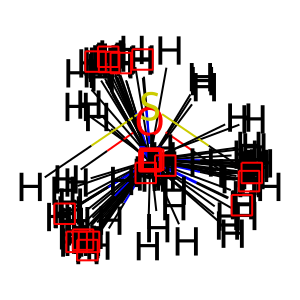

In [ ]:
# def read_xyz(file_path):
#     with open(file_path, 'r') as f:
#         lines = f.readlines()
    
#     # First line: number of atoms (can be ignored for now)
#     num_atoms = int(lines[0].strip())
    
#     # Second line: comment (optional metadata)
#     comment = lines[1].strip()
    
#     # Remaining lines: atomic symbols and coordinates
#     atoms = []
#     coordinates = []
#     for line in lines[2:]:
#         parts = line.split()
#         if len(parts) == 4:  # Ensure the line has atomic symbol and 3 coordinates
#             atom_symbol = parts[0]
#             x, y, z = map(float, parts[1:])
#             atoms.append(atom_symbol)
#             coordinates.append((x, y, z))
    
#     return atoms, coordinates

# def create_rdkit_molecule(atoms, coordinates):
#     mol = Chem.RWMol()
#     atom_indices = []
    
#     # Add atoms to the RDKit molecule
#     for atom_symbol in atoms:
#         atom = Chem.Atom(atom_symbol)
#         atom_idx = mol.AddAtom(atom)
#         atom_indices.append(atom_idx)
    
#     # Add bonds (optional, inferred later)
#     # RDKit can infer bonds when embedding the molecule
    
#     # Set 3D coordinates
#     conf = Chem.Conformer(len(atoms))
#     for i, (x, y, z) in enumerate(coordinates):
#         conf.SetAtomPosition(i, (x, y, z))
#     mol.AddConformer(conf)
    
#     return mol

# # File path to your .xyz file
# xyz_file = COORDINATES_FOLDER + "final_states_hausdorff_distance_0.5_seed_42_no_transform_transformation_seed_42_COM_addition/0_pred_.xyz"

# # Read the .xyz file
# atoms, coordinates = read_xyz(xyz_file)

# # Create an RDKit molecule
# rdkit_mol = create_rdkit_molecule(atoms, coordinates)

# # Attempt to infer bonds
# try:
#     Chem.SanitizeMol(rdkit_mol)
# except Exception as e:
#     print("Sanitization failed. Bonds could not be inferred:", e)
# # Add hydrogens to the molecule
# rdkit_mol = Chem.AddHs(rdkit_mol)

# # Embed the molecule to infer bonds
# AllChem.EmbedMolecule(rdkit_mol, AllChem.ETKDG())

# # Visualize the molecule
# img = Draw.MolToImage(rdkit_mol, size=(300, 300), kekulize=True, wedgeBonds=True)
# img.show()